In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

# Markov Chain Monte Carlo

In [3]:
class metropolis(object):
    """Class to conduct Metropolis-Hastings sampling
    
    Parameters
    ----------
    
    log_posterior : func(theta, **kwargs)
        function to return log of posterior
    
    stepsize : np.float32
        proposal distribution scale size
        
    **kwargs : 
        keyword arguments to pass to function  
"""
    def __init__(self, stepsize=0.1, log_posterior=None, **kwargs):
        self._log_posterior = log_posterior
        self.kwargs = kwargs
        self.stepsize = stepsize
        return
    def log_posterior(self, theta=None):
        """Return log of posterior
        
        Parameters
        ----------
        
        theta : ndarray of np.float32
            model parameters
            
        Returns
        -------
        
        log_posterior : np.float32
            log of posterior
"""
        return(self._log_posterior(theta, **(self.kwargs)))
    def initialize(self, theta=None):
        """Initializes the sequence
        
        Parameters
        ----------
        
        theta : ndarray of np.float32
            model parameters to initialize
            
        Notes
        -----
        
        Sets up attributes theta_c, log_posterior_c (the current parameters and their
        log posterior), theta_all, log_posterior_all (history of parameters and
        log posteriors), and nproposals_all (the number of proposals per step).
"""
        self.theta_c = np.array(theta)
        self.theta_all = np.array(self.theta_c, dtype=np.float32).reshape((1, len(theta)))
        self.log_posterior_c = self.log_posterior(theta=self.theta_c)
        self.log_posterior_all = np.array([self.log_posterior_c], dtype=np.float32)
        self.nproposals_all = np.zeros(0, dtype=np.int32)
        return
    def proposal(self):
        """Make a proposal for the next step
        
        Returns
        --------
        
        theta_p : ndarray of np.float32
            proposed step
        
        log_probability_difference : np.float32
            log of ratio of backwards to forward probability distribution for this step            
"""
        ntheta = len(self.theta_c)
        theta_p = np.random.normal(size=ntheta) * self.stepsize
        log_probability_difference = 0.  # ratio of backwards to forwards proposal distribution
        theta_p = self.theta_c + theta_p 
        return(theta_p, log_probability_difference)
    def acceptance_probability(self, log_posterior_p=None, log_probability_difference=None):
        """Acceptance probability
        
        log_posterior_p : np.float32
            log of proposed step's posterior
            
        log_probability_difference : np.float32
            log of proposed step's backwards-to-forwards ratio
"""
        log_ratio = (log_posterior_p - self.log_posterior_c + log_probability_difference)
        return(np.exp(np.min([0., log_ratio])))
    def step(self):
        """Take an MCMC step
        
        Notes
        -----
        
        Updates theta_c, log_posterior_c, theta_all, log_posterior_all, and nproposals_all 
"""
        accepted = False
        nproposals = 1
        while(accepted is False):
            theta_p, lpd = self.proposal()
            log_posterior_p = self.log_posterior(theta_p)
            aprob = self.acceptance_probability(log_posterior_p=log_posterior_p,
                                                log_probability_difference=lpd)
            if(np.random.random() < aprob):
                accepted = True
            nproposals = nproposals + 1
        self.theta_c = theta_p
        self.log_posterior_c = self.log_posterior(theta=self.theta_c)
        self.log_posterior_all = np.append(self.log_posterior_all, self.log_posterior_c)
        self.nproposals_all = np.append(self.nproposals_all, nproposals)
        self.theta_all = np.append(self.theta_all, self.theta_c).reshape(len(self.log_posterior_all),
                                                                         len(self.theta_c))
        return

In [4]:
def log_likelihood(theta, **kwargs):
    """Return log likelihood of line with variance"""
    a0 = theta[0]
    a1 = theta[1]
    logsig = theta[2]
    x = kwargs['x']
    d = kwargs['data']
    m = a0 + a1 * x
    log_likelihood = ((- 0.5 * (m - d)**2 / np.exp(2. * logsig)) 
                      - 0.5 * np.log(2. * np.pi) - logsig).sum()
    return(log_likelihood)

In [5]:
nx = 10000
x = np.random.random(nx) * 5. - 2.5
a0 = 3.
a1 = 1.5
sig = 1.
data = a0 + a1 * x + np.random.normal(size=nx) * sig
print(data)

[ 0.05819272  3.13411457 -1.81764686 ...  2.21193135  7.20691692
  0.96154218]


<IPython.core.display.Javascript object>


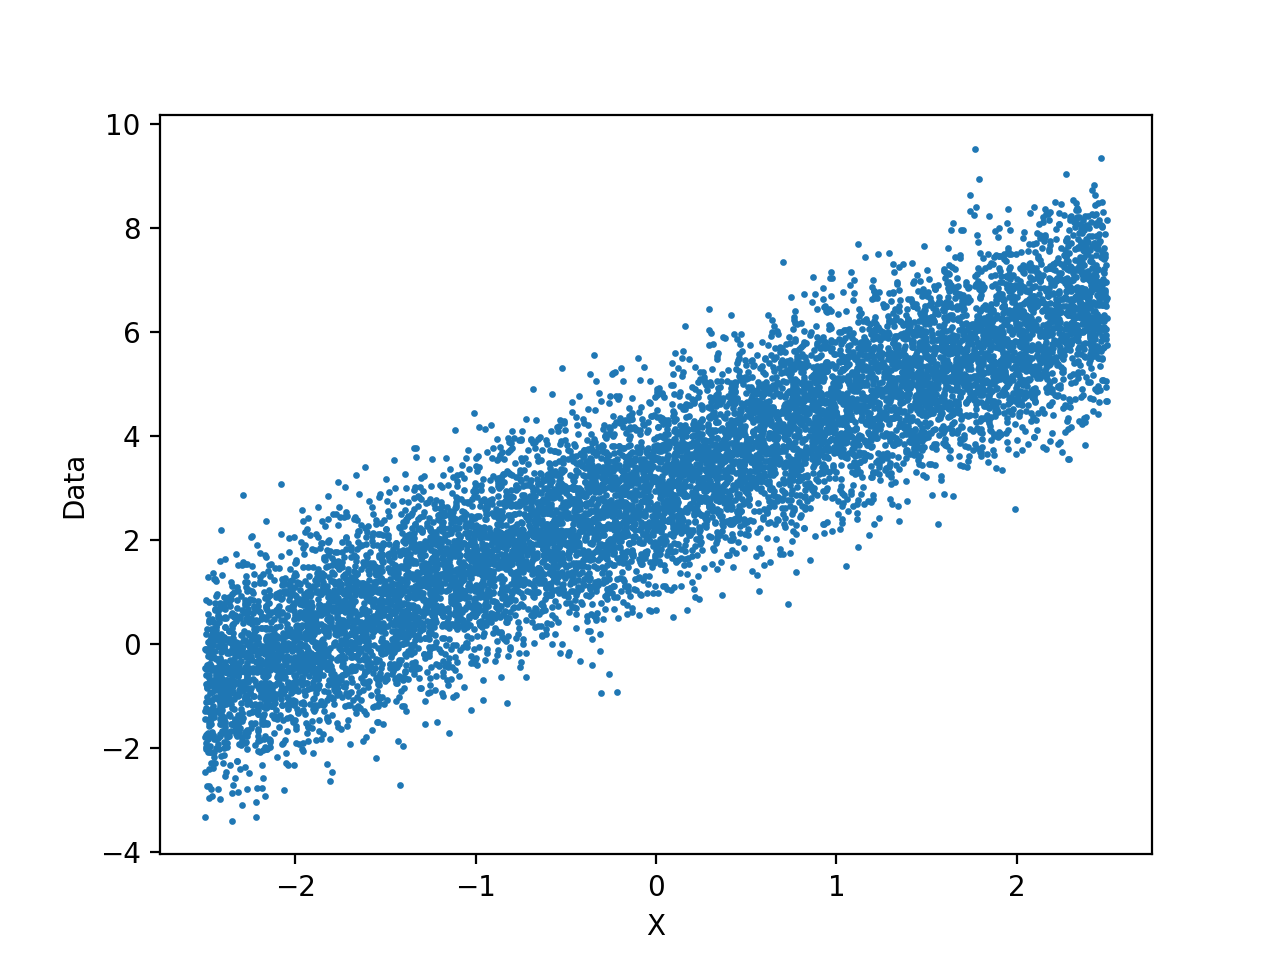

Text(0, 0.5, 'Data')

In [6]:
plt.scatter(x, data, s=2)
plt.xlabel('X')
plt.ylabel('Data')

In [7]:
met = metropolis(log_posterior=log_likelihood, stepsize=0.001,
                 data=data, x=x)

In [8]:
%timeit  for i in range(1000):  met.initialize([1., 1., 0.]);  met.step()

130 ms ± 465 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
met.initialize([1., 1., 0.])
for i in range(10000): met.step()

<IPython.core.display.Javascript object>


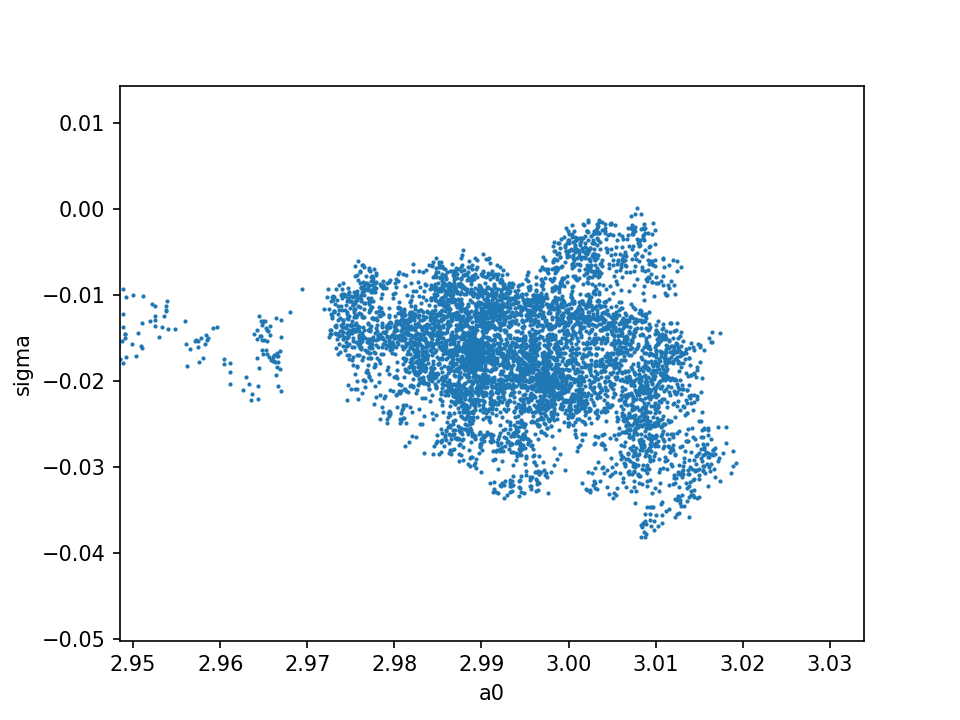

Text(0, 0.5, 'sigma')

In [13]:
plt.scatter(met.theta_all[:, 0], met.theta_all[:, 2], s=1)
plt.xlabel('a0')
plt.ylabel('sigma')

<IPython.core.display.Javascript object>


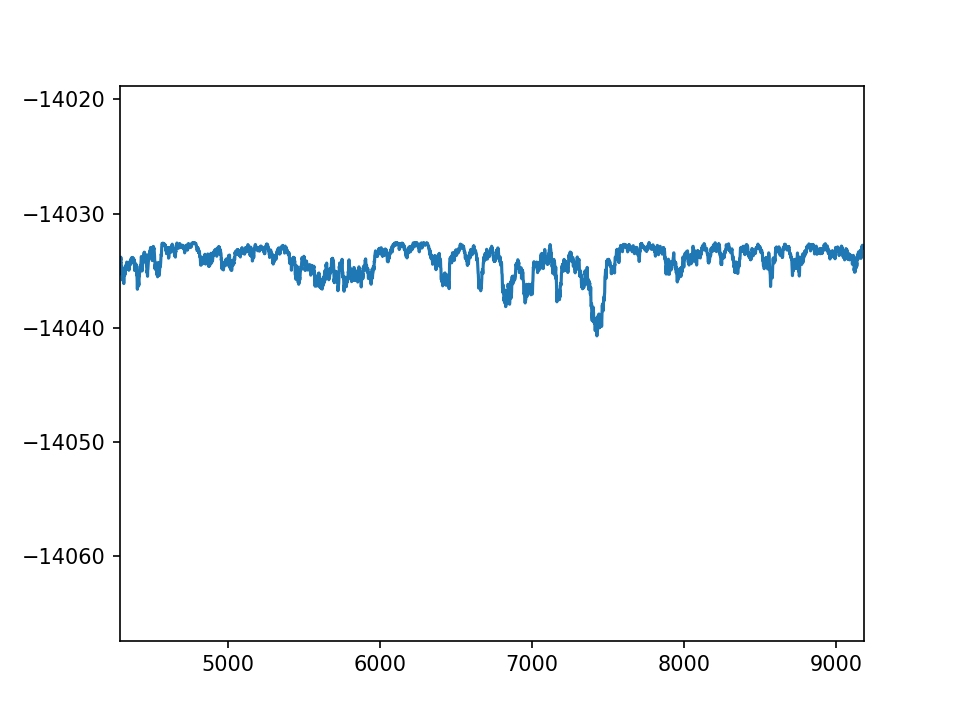

In [14]:
plt.plot(met.log_posterior_all)

We can be much more efficient in calculating the likelihood, because actually we only are acting on the moments of the data:


$$\log L = \sum_i \left[ -\frac{1}{2} \frac{(m_i - d_i)^2}{\sigma^2} - \frac{1}{2}\log(2\pi) - \log\sigma \right]$$

$$\log L = \sum_i \left[ -\frac{1}{2} \frac{(a_0 + a_1 x_i - d_i)^2}{\sigma^2} - \frac{1}{2}\log(2\pi) - \log\sigma \right]$$

$$\log L = N\left(- \frac{1}{2}\log(2\pi) - \log\sigma \right)
- \frac{1}{2} \frac{1}{\sigma^2} \sum_i (a_0 + a_1 x_i - d_i)^2$$

$$\log L = N\left(- \frac{1}{2}\log(2\pi) - \log\sigma \right)
- \frac{1}{2} \frac{1}{\sigma^2} \sum_i \left(a_0^2 + a_1^2 x_i^2 + d_i^2 + 2 a_0 a_1 x_i - 2 a_0 d_i - 2a_1 x_i d_i\right)$$

$$\log L = N\left(- \frac{1}{2}\log(2\pi) - \log\sigma \right)
- N \frac{1}{2} \frac{1}{\sigma^2} \left( a_0^2 + a_1^2 \langle x^2\rangle + \langle d^2 \rangle
+ 2 a_0 a_1 \langle x\rangle - 2 a_0 \langle d\rangle -2 a_1 \langle x d\rangle \right) $$

In [89]:
def log_likelihood_efficient(theta, **kwargs):
    """Return log likelihood of line with variance"""
    a0 = theta[0]
    a1 = theta[1]
    logsig = theta[2]
    N = kwargs['N']
    x_mean = kwargs['x_mean']
    d_mean = kwargs['data_mean']
    x2_mean = kwargs['x2_mean']
    d2_mean = kwargs['data2_mean']
    xd_mean = kwargs['xd_mean']
    log_likelihood = N * (0.5 * np.log(2. * np.pi) - logsig
                          - 0.5 * (1. / np.exp(logsig * 2)) * 
                          (a0**2 + a1**2 * x2_mean + d2_mean + 2. * a0 * a1 * x_mean
                          - 2. * a0 * d_mean - 2. * a1 * xd_mean))
    return(log_likelihood)

In [100]:
N = len(data)
x_mean = x.mean()
data_mean = data.mean()
x2_mean = (x**2).mean()
data2_mean = (data**2).mean()
xd_mean = (data * x).mean()
met = metropolis(log_posterior=log_likelihood_efficient, stepsize=0.001, N=N, x_mean=x_mean,
                 data_mean=data_mean, data2_mean=data2_mean, x2_mean=x2_mean, xd_mean=xd_mean)

In [101]:
%timeit for i in range(1000): met.initialize([1., 1., 0.]); met.step() 

30.6 ms ± 251 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [123]:
met.initialize([1., 1., 0.])
for i in range(10000): met.step()

<IPython.core.display.Javascript object>


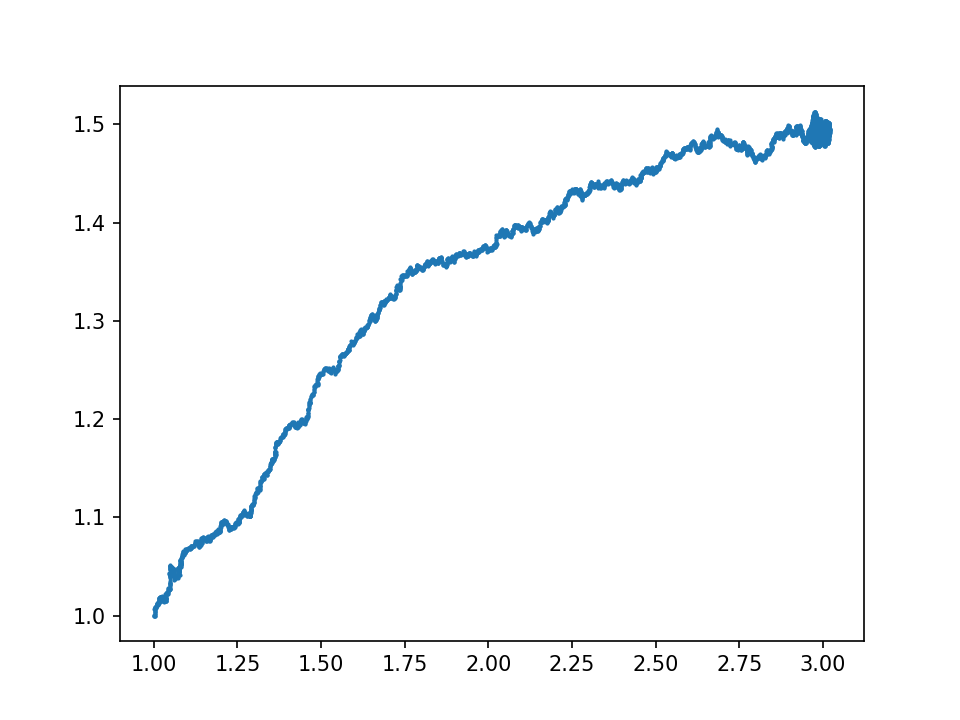

In [124]:
plt.scatter(met.theta_all[:, 0], met.theta_all[:, 1], s=1)

<IPython.core.display.Javascript object>


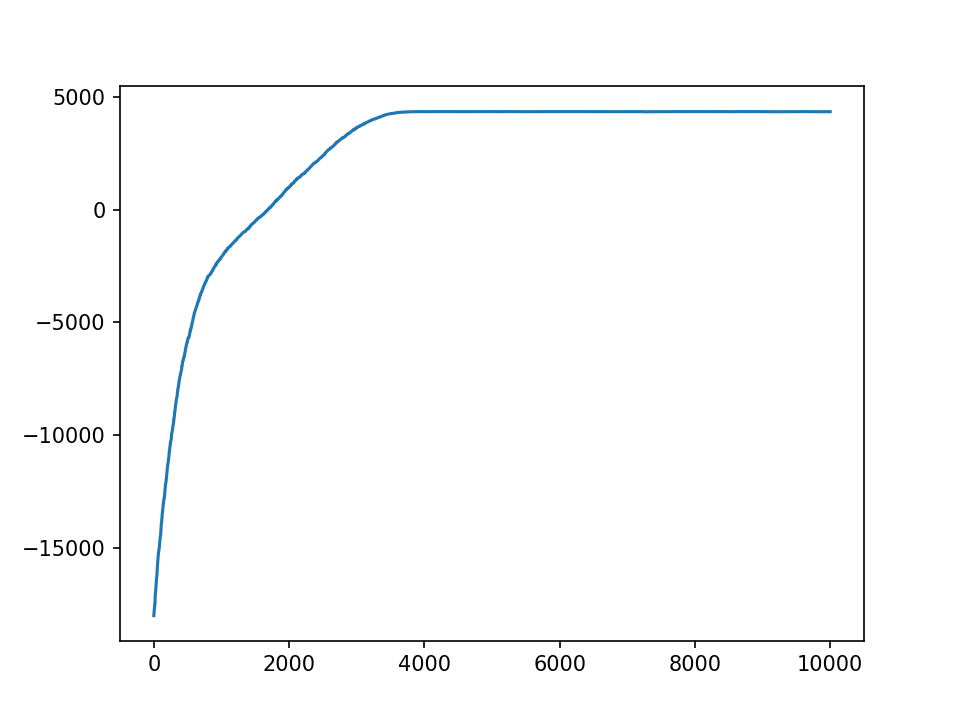

In [125]:
plt.plot(met.log_posterior_all)

In [106]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

In [130]:
section = met.log_posterior_all[4000:6000]
std = np.std(section)
acorr = autocorr((section - section.mean()) / std)

<IPython.core.display.Javascript object>


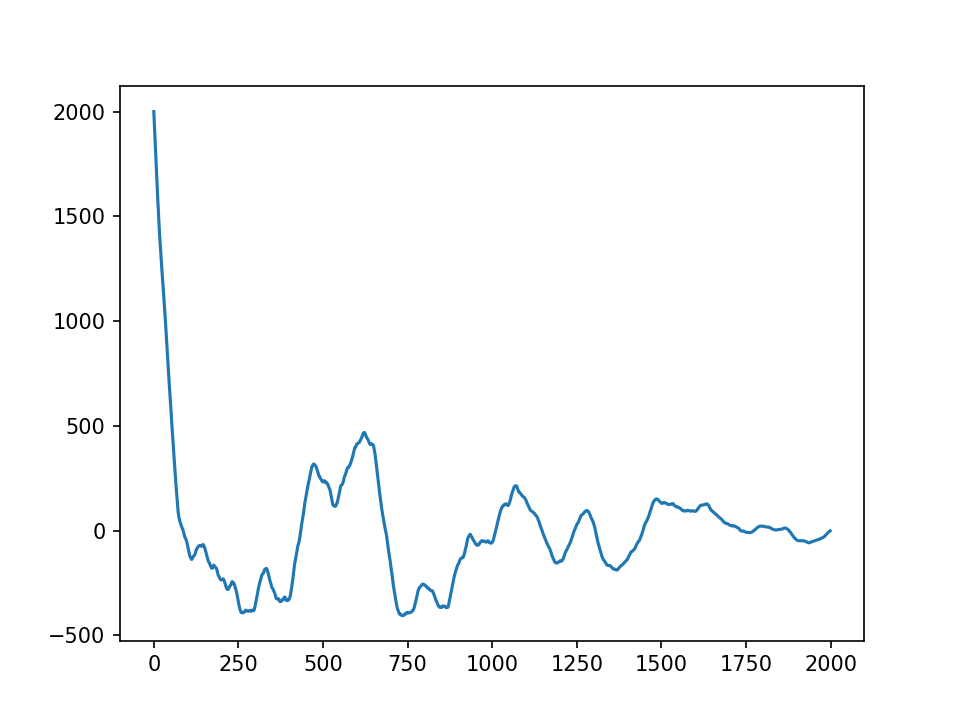

In [131]:
plt.plot(acorr)

In [146]:
tauf = 1. + 2. * (np.arange(499) * acorr[1:500] / acorr[0]).sum()

In [147]:
print(tauf)

-14042.38891562925
